In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    # original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0520/weights_KD_segformer_0520_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.9
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0825

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - loss: 0.0694
Average validation loss: 0.6658807992935181
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 551ms/step - loss: 0.0694 - val_loss: 0.6659
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 546ms/step - loss: 0.0540 - val_loss: 0.6659
Average validation loss: 0.5437221527099609
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 558ms/step - loss: 0.0540 - val_loss: 0.6048
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 835ms/step - loss: 0.0430 - val_loss: 0.6048
Average validation loss: 0.33143651485443115
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 853ms/step - loss: 0.0430 - val_loss: 0.5137
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segf

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 836ms/step - loss: 0.0064
Average validation loss: 0.3189903572201729
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 850ms/step - loss: 0.0064 - val_loss: 0.3190
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 878ms/step - loss: 0.0056 - val_loss: 0.3190
Average validation loss: 0.1808496080338955
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 894ms/step - loss: 0.0056 - val_loss: 0.2499
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 832ms/step - loss: 0.0051 - val_loss: 0.2499
Average validation loss: 0.12571154534816742
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 847ms/step - loss: 0.0051 - val_loss: 0.2085
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_K

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 865ms/step - loss: 0.0037
Average validation loss: 0.08186017349362373
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 879ms/step - loss: 0.0037 - val_loss: 0.0819
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 811ms/step - loss: 0.0032 - val_loss: 0.0819
Average validation loss: 0.04266335101177295
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 826ms/step - loss: 0.0032 - val_loss: 0.0623
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 842ms/step - loss: 0.0029 - val_loss: 0.0623
Average validation loss: 0.04865050967782736
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 853ms/step - loss: 0.0029 - val_loss: 0.0577
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 812ms/step - loss: 0.0026 - val_loss: 0.0577
Avera

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 795ms/step - loss: 0.0013
Average validation loss: 0.09522521030157804
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 808ms/step - loss: 0.0013 - val_loss: 0.0952
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 816ms/step - loss: 0.0011 - val_loss: 0.0952
Average validation loss: 0.027702912455424666
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 829ms/step - loss: 0.0011 - val_loss: 0.0615
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 793ms/step - loss: 9.9814e-04 - val_loss: 0.0615
Average validation loss: 0.006687171844532713
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 807ms/step - loss: 9.9814e-04 - val_loss: 0.0432
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_K

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 811ms/step - loss: 0.0021
Average validation loss: 0.012247498938813805
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 823ms/step - loss: 0.0021 - val_loss: 0.0122
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 788ms/step - loss: 0.0016 - val_loss: 0.0122
Average validation loss: 0.00528587382286787
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 801ms/step - loss: 0.0016 - val_loss: 0.0088
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 796ms/step - loss: 0.0013 - val_loss: 0.0088
Average validation loss: 0.005507900845259428
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 808ms/step - loss: 0.0013 - val_loss: 0.0077
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 799ms/step - loss: 0.0011 - val_loss: 0.0077
Ave

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 839ms/step - loss: 0.0020
Average validation loss: 0.00781770283356309
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 851ms/step - loss: 0.0020 - val_loss: 0.0078
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 804ms/step - loss: 0.0016 - val_loss: 0.0078
Average validation loss: 0.010502761016444614
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 815ms/step - loss: 0.0016 - val_loss: 0.0092
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 801ms/step - loss: 0.0014 - val_loss: 0.0092
Average validation loss: 0.008739421687399348
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 812ms/step - loss: 0.0014 - val_loss: 0.0090
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 802ms/step - loss: 0.0012 - val_loss: 0.0090
Average validation loss: 0.0024955511617008597
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 814ms/step - loss: 0.0012 - val_loss: 0.0074
Saved model weights to 'c:\天_11157065

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 868ms/step - loss: 0.0018
Average validation loss: 0.24156356360763312
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 881ms/step - loss: 0.0018 - val_loss: 0.2416
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 791ms/step - loss: 0.0015 - val_loss: 0.2416
Average validation loss: 0.01655235576617997
40/40 ━━━━━━━━━━━━━━━━━━━━ 67s 804ms/step - loss: 0.0015 - val_loss: 0.1291
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 99s 792ms/step - loss: 0.0013 - val_loss: 0.1291
Average validation loss: 0.020699768656049854
40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 805ms/step - loss: 0.0013 - val_loss: 0.0929
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 131s 796ms/step - loss: 0.0011 - val_loss: 0.0929
Av

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 774ms/step - loss: 0.0012
Average validation loss: 0.01070238413133969
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 0.0012 - val_loss: 0.0107
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 826ms/step - loss: 9.8083e-04 - val_loss: 0.0107
Average validation loss: 0.02450360730290413
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 840ms/step - loss: 9.8083e-04 - val_loss: 0.0176
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 118s 829ms/step - loss: 8.3035e-04 - val_loss: 0.0176
Average validation loss: 0.008675539461061513
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 843ms/step - loss: 8.3035e-04 - val_loss: 0.0146
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_60.pth'.
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 161s 871ms/step - loss: 7.3206e-04 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 798ms/step - loss: 9.5859e-04
Average validation loss: 0.017677225904273137
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 812ms/step - loss: 9.5859e-04 - val_loss: 0.0177
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 795ms/step - loss: 7.6711e-04 - val_loss: 0.0177
Average validation loss: 0.023558551711695536
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 808ms/step - loss: 7.6711e-04 - val_loss: 0.0206
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 800ms/step - loss: 6.6370e-04 - val_loss: 0.0206
Average validation loss: 0.012810860045387276
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 813ms/step - loss: 6.6370e-04 - val_loss: 0.0180
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 181s 801ms/step - loss: 6

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 792ms/step - loss: 6.5708e-04
Average validation loss: 0.11640695622190833
64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 806ms/step - loss: 6.5708e-04 - val_loss: 0.1164
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 801ms/step - loss: 6.0747e-04 - val_loss: 0.1164
Average validation loss: 0.009267618690500967
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 814ms/step - loss: 6.0747e-04 - val_loss: 0.0628
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 804ms/step - loss: 5.7421e-04 - val_loss: 0.0628
Average validation loss: 0.007154914768761955
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 817ms/step - loss: 5.7421e-04 - val_loss: 0.0443
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 793ms/step - loss: 5.7509e-04
Average validation loss: 0.013751961834107837
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 806ms/step - loss: 5.7509e-04 - val_loss: 0.0138
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 119s 850ms/step - loss: 4.9251e-04 - val_loss: 0.0138
Average validation loss: 0.009476997064161373
72/72 ━━━━━━━━━━━━━━━━━━━━ 120s 863ms/step - loss: 4.9251e-04 - val_loss: 0.0116
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 181s 843ms/step - loss: 4.3000e-04 - val_loss: 0.0116
Average validation loss: 0.006869326329453745
72/72 ━━━━━━━━━━━━━━━━━━━━ 182s 857ms/step - loss: 4.3000e-04 - val_loss: 0.0100
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 809ms/step - loss: 5.3122e-04
Average validation loss: 0.0031838192357099616
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 822ms/step - loss: 5.3122e-04 - val_loss: 0.0032
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 791ms/step - loss: 4.9169e-04 - val_loss: 0.0032
Average validation loss: 0.00224784388919943
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 804ms/step - loss: 4.9169e-04 - val_loss: 0.0027
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 800ms/step - loss: 4.6258e-04 - val_loss: 0.0027
Average validation loss: 0.0036930677597410977
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 813ms/step - loss: 4.6258e-04 - val_loss: 0.0030
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 260s 809ms/step - lo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 800ms/step - loss: 6.6434e-04
Average validation loss: 0.008274204357197354
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 813ms/step - loss: 6.6434e-04 - val_loss: 0.0083
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 794ms/step - loss: 5.3552e-04 - val_loss: 0.0083
Average validation loss: 0.013374652107207416
96/96 ━━━━━━━━━━━━━━━━━━━━ 156s 807ms/step - loss: 5.3552e-04 - val_loss: 0.0108
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 232s 796ms/step - loss: 4.6948e-04 - val_loss: 0.0108
Average validation loss: 0.008359078691379787
96/96 ━━━━━━━━━━━━━━━━━━━━ 233s 810ms/step - loss: 4.6948e-04 - val_loss: 0.0100
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 310s 793ms/step - loss: 4.4040e-04 - val_loss: 0.0100
Average validation loss: 0.017360332785756327
96/96 ━━━━━━━━━━━━━━━━━━━━ 311s 806ms/step - loss: 4.4040e-04 - val_loss: 0.011

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 797ms/step - loss: 8.6880e-04
Average validation loss: 0.007070088076094786
120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 810ms/step - loss: 8.6880e-04 - val_loss: 0.0071
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 795ms/step - loss: 7.0531e-04 - val_loss: 0.0071
Average validation loss: 0.005222582370818903
120/120 ━━━━━━━━━━━━━━━━━━━━ 194s 809ms/step - loss: 7.0531e-04 - val_loss: 0.0061
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 290s 793ms/step - loss: 6.1876e-04 - val_loss: 0.0061
Average validation loss: 0.009962236774542058
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 806ms/step - loss: 6.1876e-04 - val_loss: 0.0074
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 387s 79

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 796ms/step - loss: 8.3278e-04
Average validation loss: 0.006914420781767048
144/144 ━━━━━━━━━━━━━━━━━━━━ 117s 809ms/step - loss: 8.3278e-04 - val_loss: 0.0069
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 230s 791ms/step - loss: 6.5630e-04 - val_loss: 0.0069
Average validation loss: 0.005879355978524675
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 803ms/step - loss: 6.5630e-04 - val_loss: 0.0064
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 347s 800ms/step - loss: 5.8547e-04 - val_loss: 0.0064
Average validation loss: 0.004110753410511986
144/144 ━━━━━━━━━━━━━━━━━━━━ 349s 812ms/step - loss: 5.8547e-04 - val_loss: 0.0056
Saved model weights to 'c:\天_11157065\git\Rip

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 147s 916ms/step - loss: 5.5675e-04
Average validation loss: 0.006540321419015527
160/160 ━━━━━━━━━━━━━━━━━━━━ 149s 930ms/step - loss: 5.5675e-04 - val_loss: 0.0065
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 276s 793ms/step - loss: 4.6023e-04 - val_loss: 0.0065
Average validation loss: 0.004025285585521487
160/160 ━━━━━━━━━━━━━━━━━━━━ 278s 806ms/step - loss: 4.6023e-04 - val_loss: 0.0053
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 405s 795ms/step - loss: 4.0849e-04 - val_loss: 0.0053
Average validation loss: 0.005815235109912465
160/160 ━━━━━━━━━━━━━━━━━━━━ 407s 808ms/step - loss: 4.0849e-04 - val_loss: 0.0055
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 535s 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 794ms/step - loss: 6.3521e-04
Average validation loss: 0.007435702354705427
200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 807ms/step - loss: 6.3521e-04 - val_loss: 0.0074
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 323s 810ms/step - loss: 5.2399e-04 - val_loss: 0.0074
Average validation loss: 0.00485535017643997
200/200 ━━━━━━━━━━━━━━━━━━━━ 326s 823ms/step - loss: 5.2399e-04 - val_loss: 0.0061
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 494s 842ms/step - loss: 4.6490e-04 - val_loss: 0.0061
Average validation loss: 0.005223009584401552
200/200 ━━━━━━━━━━━━━━━━━━━━ 497s 854ms/step - loss: 4.6490e-04 - val_loss: 0.0058
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 656s 7

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 797ms/step - loss: 5.0723e-04
Average validation loss: 0.005868769042232695
240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 809ms/step - loss: 5.0723e-04 - val_loss: 0.0059
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 390s 814ms/step - loss: 4.3402e-04 - val_loss: 0.0059
Average validation loss: 0.0032874386102776042
240/240 ━━━━━━━━━━━━━━━━━━━━ 393s 827ms/step - loss: 4.3402e-04 - val_loss: 0.0046
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0520/weights_KD_segformer_0520_90\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 585s 801ms/step - loss: 3.8241e-04 - val_loss: 0.0046
Average validation loss: 0.003991312473642594
240/240 ━━━━━━━━━━━━━━━━━━━━ 588s 814ms/step - loss: 3.8241e-04 - val_loss: 0.0044
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 781s

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.17168039023876192, 0.07897848752792924, 0.026057011038064955, 0.011493987854919396, 0.013701476457994428, 0.024063669403258246, 0.01840850610187044, 0.01609482735414834, 0.01139960384295721, 0.011344014765527391, 0.005367048746751001, 0.005765974536785507, 0.004293117788753686, 0.004357771419531976, 0.005020810727276468, 0.004431946973235157, 0.005039559078746975, 0.003575619928080826]
std_val_losses =  [0.12632797759927353, 0.07769341081968112, 0.023204808536083654, 0.016641196009754763, 0.026090007766947844, 0.06391423428989099, 0.035372889688469966, 0.02774698162847571, 0.014090973306655773, 0.021314445112570538, 0.005835238538069416, 0.01007632533917692, 0.004107095232810123, 0.0022771325955164984, 0.005356799751791359, 0.004116800426246999, 0.006539628233031991, 0.003186237957892914]


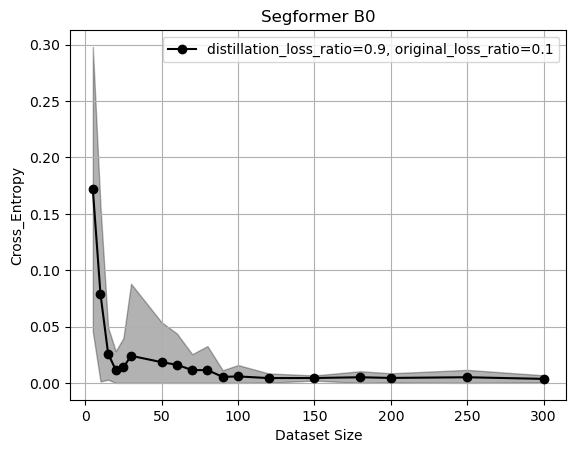

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0520')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0520_{int(teacher_ratio*100)}.png"))

plt.show()